# DD-SV Neuron Synapse Competition

## Load in and Wrangle Training Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#load in training data on each potential synapse
data = pd.read_csv("./train_data.csv")

#load in additional features for each neuron
feature_weights = pd.read_csv("./feature_weights.csv")
morph_embeddings = pd.read_csv("./morph_embeddings.csv")

#### Merge Data

In [3]:
# join all feature_weight_i columns into a single np.array column
feature_weights["feature_weights"] = (
    feature_weights.filter(regex="feature_weight_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the feature_weight_i columns
feature_weights.drop(
    feature_weights.filter(regex="feature_weight_").columns, axis=1, inplace=True
)

# join all morph_embed_i columns into a single np.array column
morph_embeddings["morph_embeddings"] = (
    morph_embeddings.filter(regex="morph_emb_")
    .sort_index(axis=1)
    .apply(lambda x: np.array(x), axis=1)
)
# delete the morph_embed_i columns
morph_embeddings.drop(
    morph_embeddings.filter(regex="morph_emb_").columns, axis=1, inplace=True
)

In [4]:
data = (
    data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [5]:
print("Data Size:",data.shape)
print("\nData:")
data.info()

Data Size: (185832, 34)

Data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 185832 entries, 0 to 185831
Data columns (total 34 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   ID                              185832 non-null  int64  
 1   axonal_coor_x                   185832 non-null  int64  
 2   axonal_coor_y                   185832 non-null  int64  
 3   axonal_coor_z                   185832 non-null  int64  
 4   dendritic_coor_x                185832 non-null  int64  
 5   dendritic_coor_y                185832 non-null  int64  
 6   dendritic_coor_z                185832 non-null  int64  
 7   adp_dist                        185832 non-null  float64
 8   post_skeletal_distance_to_soma  185832 non-null  float64
 9   pre_skeletal_distance_to_soma   185832 non-null  float64
 10  pre_oracle                      185832 non-null  float64
 11  pre_test_score                  185832 non-null

## Feature Engineering

In [10]:
#cosine similarity function
def row_feature_similarity(row):
    pre = row["pre_feature_weights"]
    post = row["post_feature_weights"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    return abs(dendriticX - axonalX)
def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    return abs(dendriticY - axonalY)
def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    return abs(dendriticZ - axonalZ)

def EDax_denDist(row):
#def xCoorDifference(row):
    dendriticX = row["dendritic_coor_x"]
    axonalX = row["axonal_coor_x"]
    #return abs(dendriticX - axonalX)
#def yCoorDifference(row):
    dendriticY = row["dendritic_coor_y"]
    axonalY = row["axonal_coor_y"]
    #return abs(dendriticY - axonalY)
#def zCoorDifference(row):
    dendriticZ = row["dendritic_coor_z"]
    axonalZ = row["axonal_coor_z"]
    #return abs(dendriticZ - axonalZ)
    return ((dendriticX - axonalX)**2 
            + (dendriticY - axonalY)**2 
            + (dendriticZ - axonalZ)**2)**(1/2)

def EDpre_postnucleusDist(row):
    preNucleusX = row["pre_nucleus_x"]
    preNucleusY = row["pre_nucleus_y"]
    preNucleusZ = row["pre_nucleus_z"]

    postNucleusX = row["post_nucleus_x"]
    postNucleusY = row["post_nucleus_y"]
    postNucleusZ = row["post_nucleus_z"]
    return np.sqrt((preNucleusX-postNucleusX)**2 
                   + (preNucleusY-postNucleusY)**2 
                   + (preNucleusZ-postNucleusZ)**2)

def thetaDiff(row):
    pre_orientation_vector_X = row["axonal_coor_x"] - row["pre_nucleus_x"]
    pre_orientation_vector_Y = row["axonal_coor_y"] - row["pre_nucleus_y"]
    pre_orientation_vector_Z = row["axonal_coor_z"] - row["pre_nucleus_z"]

    post_orientation_vector_X = row["dendritic_coor_x"] - row["post_nucleus_x"]
    post_orientation_vector_Y = row["dendritic_coor_y"] - row["post_nucleus_y"]
    post_orientation_vector_Z = row["dendritic_coor_z"] - row["post_nucleus_z"]
    
    numerator = (pre_orientation_vector_X
                 * post_orientation_vector_X
                 + pre_orientation_vector_Y * post_orientation_vector_Y
                 + pre_orientation_vector_Z * post_orientation_vector_Z
                 )
    denominator = (np.sqrt(pre_orientation_vector_X**2
                    + pre_orientation_vector_Y**2
                    + pre_orientation_vector_Z**2)
                    * (np.sqrt(post_orientation_vector_X**2
                    + post_orientation_vector_Y**2
                    + post_orientation_vector_Z**2))
                   )
    cos_theta = numerator / denominator
    actual_angle = np.arccos(cos_theta)*(180/np.pi)
    return actual_angle

#cosine similarity function
def row_morphEmbed_similarity(row):
    pre = row["pre_morph_embeddings"]
    post = row["post_morph_embeddings"]
    return (pre * post).sum() / (np.linalg.norm(pre) * np.linalg.norm(post))

# location slicer relative to lop left of monitor
def preRadialLocation(row):
    pre = row["pre_rf_x"]
    post = row["pre_rf_y"]
    return np.sqrt(pre**2 * post**2)

def postRadialLocation(row):
    pre = row["post_rf_x"]
    post = row["post_rf_y"]
    return np.sqrt(pre**2 * post**2)

def oracleDiff(row):
    pre = row["pre_oracle"]
    post = row["post_oracle"]
    return pre * post

def testScoreDiff(row):
    pre = row["pre_test_score"]
    post = row["post_test_score"]
    return pre * post

# compute the cosine similarity between the pre- and post- feature weights
data["fw_similarity"] = data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings
data["morphEm_similarity"] = data.apply(row_morphEmbed_similarity, axis=1)
# compute the difference between the X-coordinates
data["coorX_difference"] = data.apply(xCoorDifference, axis=1)
# compute the difference between the Y-coordinates
data["coorY_difference"] = data.apply(yCoorDifference, axis=1)
# compute the difference between the Z-coordinates
data["coorZ_difference"] = data.apply(zCoorDifference, axis=1)
# Theta between 2 neurons
data["theta_btwn_2neurons"] = data.apply(thetaDiff, axis =1)
# 3D distance between axon and dendrite 
data["3Dax_denDist"] = data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
data["3Dpre_postNucleusDist"] = data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location
data["preRadialLocation"] = data.apply(preRadialLocation, axis=1)
# Post radial location
data["postRadialLocation"] = data.apply(postRadialLocation, axis=1)
# Combined Oracle Score of Pre-synaptic and Post-synaptic Neurons:
data["Combined_oracle"] = data.apply(oracleDiff, axis=1)
# pre and post test score difference 
data["Combined_testScore"] = data.apply(testScoreDiff, axis=1)

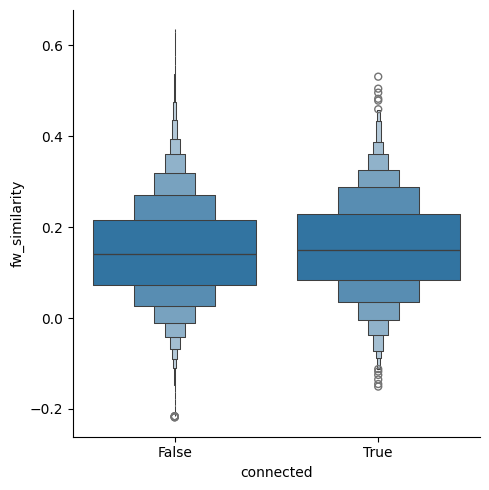

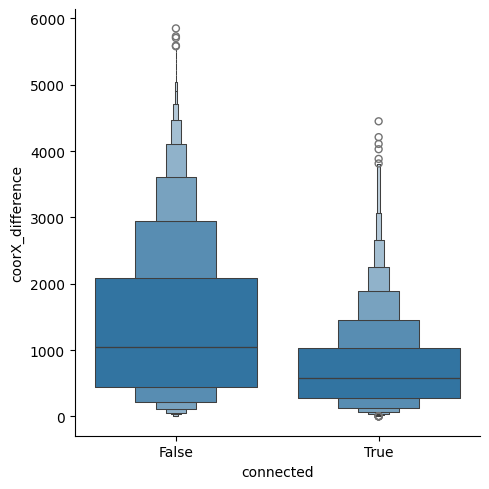

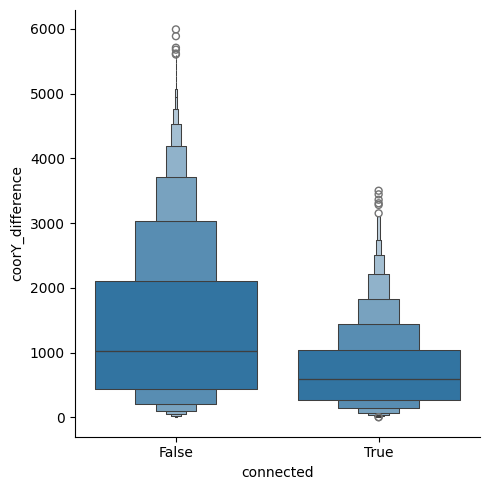

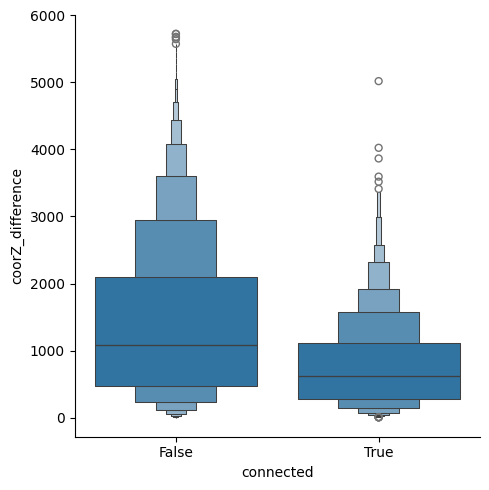

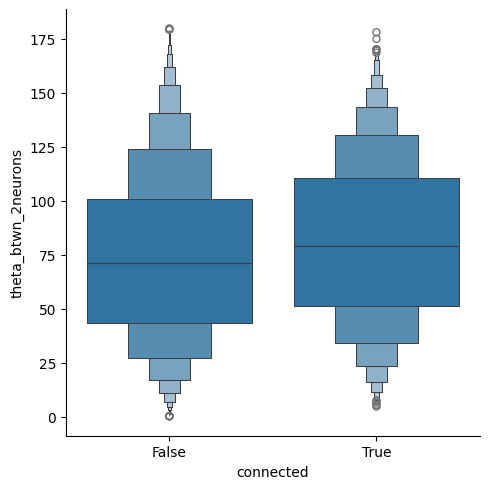

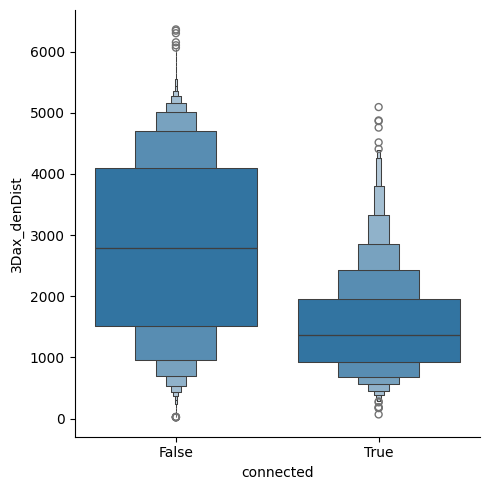

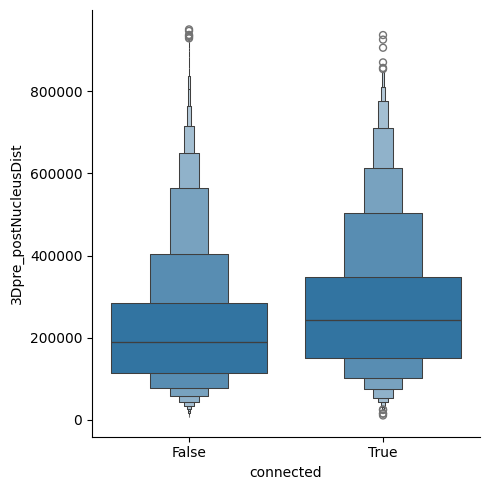

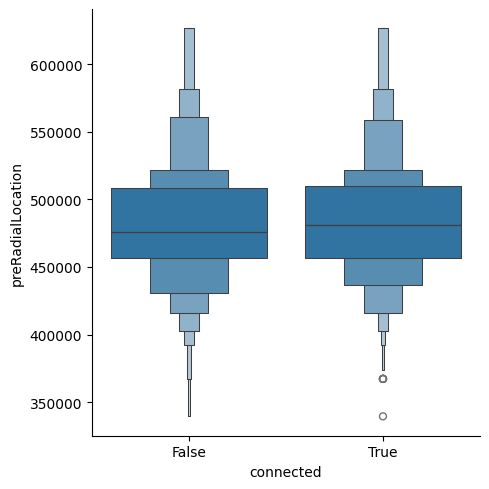

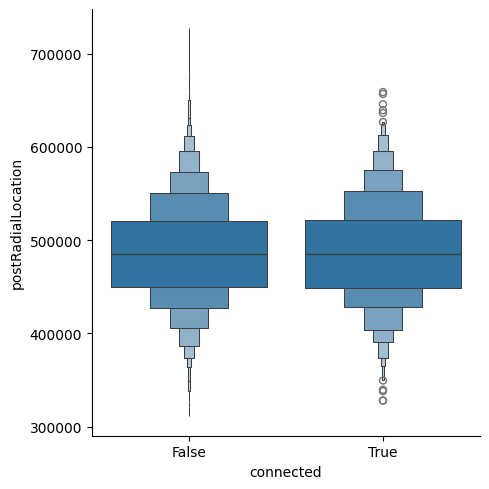

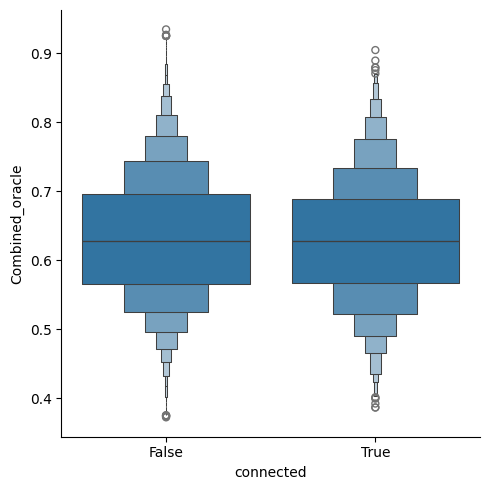

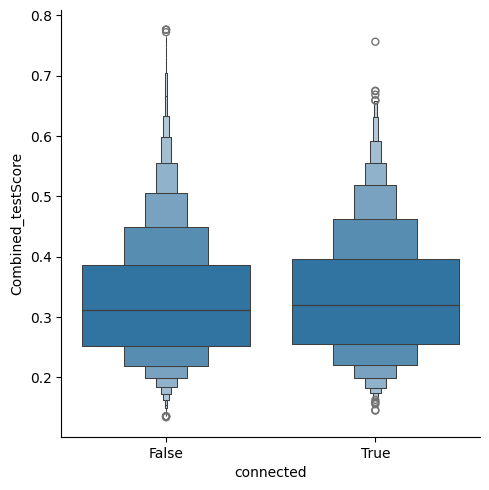

In [11]:
#visualize these results
sns.catplot(data=data, x='connected', y='fw_similarity', kind='boxen')
sns.catplot(data=data, x='connected', y='coorX_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorY_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='coorZ_difference', kind='boxen')
sns.catplot(data=data, x='connected', y='theta_btwn_2neurons', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dax_denDist', kind='boxen')
sns.catplot(data=data, x='connected', y='3Dpre_postNucleusDist', kind='boxen')
sns.catplot(data=data, x='connected', y='preRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='postRadialLocation', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_oracle', kind='boxen')
sns.catplot(data=data, x='connected', y='Combined_testScore', kind='boxen')

There may be a very, very slight difference, but we can investigate this further.

### Exploration: Similar functional nerual responses by projection region in the brain

Projection regions indicate the brain regions where the pre-synaptic and post-synaptic neurons are located in the brain.  Each brain region is responsible for different neural functions.  We can engineer a new feature to capture the projection regions and perhaps see if similar neural tuning is affiliated with connecitons in particular projection regions.  For example, it has been shown that connected neurons have slightly more similar neural tuning than unconnected neurons in the V1->V1 projection region.

In [12]:
# generate projection group as pre->post
data["projection_group"] = (
    data["pre_brain_area"].astype(str)
    + "->"
    + data["post_brain_area"].astype(str)
)

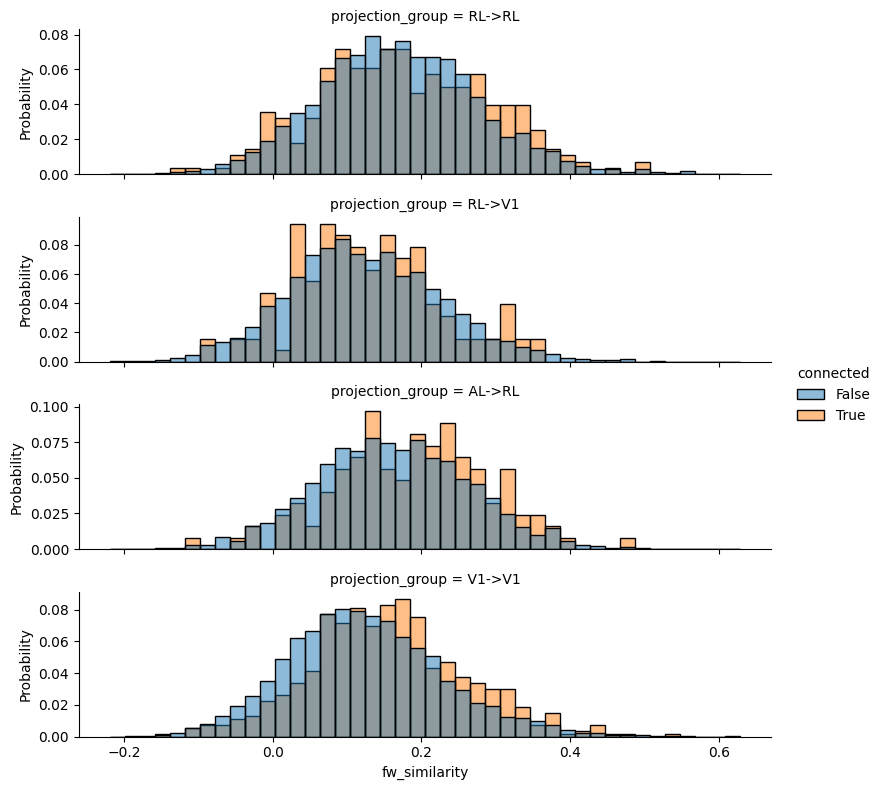

In [13]:
# check the distribution of the cosine similarity for projections groups with more than 100 synapses
projection_group_counts = data.query('connected')['projection_group'].value_counts()
projection_group_counts = projection_group_counts[projection_group_counts > 100].index
sns.displot(
    data=data.query('projection_group in @projection_group_counts'), 
    x='fw_similarity', 
    hue='connected', 
    row='projection_group',
    common_norm=False, 
    stat='probability',
    binwidth=.02,
    height=2,
    aspect=4,
    facet_kws={'sharey': False}
)

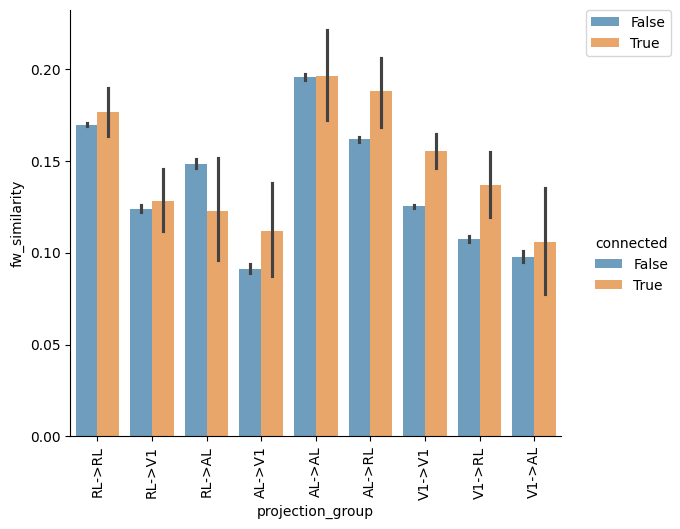

In [14]:
sns.catplot(data=data, x='projection_group', y='fw_similarity', hue='connected', kind='bar', alpha=.7)
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.);
plt.xticks(rotation=90);

We have shown some simple examples of how to engineer new features and also shown that these are related to neuron connectivity.  You will likley need to explore and engineer many other possible features in this competition.  

## Example: Simple Logistic Regression

Now that we have shown some features are associated with neuron connectivity, we fit a simple calssification model: Logistic Regression.

In [15]:
# logistic regression model (connected ~ fw_similarity + adp)
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import balanced_accuracy_score, accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# split into a train and test set 
#(Even though we're working with the competition training set, you may want to have your own internal train and test sets.)
train_data, test_data = train_test_split(data, test_size=0.2, random_state=1)

# create pipeline
pipe = Pipeline(
    [("scaler", StandardScaler()), ("model", LogisticRegression(random_state=2))]
)

# fit model
pipe.fit(train_data[["fw_similarity", "adp_dist"]], train_data["connected"])

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"]])[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")


accuracy: 0.9927085855732236


Wow.  This looks like terrific accuracy.  But, remember the data is unbalanced.  Let's check the confusion matrix.

In [16]:
confusion_matrix(test_data['connected'], test_data['pred'] > .5)

array([[36896,     0],
       [  271,     0]])

The model always predicts not connected!  We need a new evaluation metric.

### Balanced Accuracy Metric

Sensitivity = True Positive Rate = True Positive / (True Positive + False Negative)
Specificity = True Negative Rate = True Negative / (True Negative + False Positive)

Balanced Accuracy = (Sensitivity + Specificity)/2

In [17]:
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

balanced accuracy: 0.5


## Data Augmentation for Unbalanced Classification

As our simple model always predicts not connected, we need to use some technique that balances the two classes.  While there are many strategies one can employ, we demostrate a simple random over sampling strategy that uses the bootstrap to augment the data for the minority ('connected') class.  

In [18]:
from imblearn.over_sampling import RandomOverSampler

# oversample connected neuron pairs
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(
    train_data[["fw_similarity", "adp_dist"]], train_data["connected"]
)

# fit model
pipe.fit(X_resampled, y_resampled)

# predict on test data
test_data["pred"] = pipe.predict_proba(test_data[["fw_similarity", "adp_dist"]])[:, 1]

# compute accuracy
print(f"accuracy: {accuracy_score(test_data['connected'], test_data['pred'] > .5)}")

# confusion matrix
print(confusion_matrix(test_data['connected'], test_data['pred'] > .5))

# compute balanced accuracy
print(
    f"balanced accuracy: {balanced_accuracy_score(test_data['connected'], test_data['pred'] > .5)}"
)

accuracy: 0.647752038098313
[[23859 13037]
 [   55   216]]
balanced accuracy: 0.7218517172433216


Simple data augmentation improves our balanced accuracy dramatically!

# Create Example Prediction File for Leaderboard Submission

### Load and Merge Leaderboard Data

In [19]:
#we need to first load and merge the leaderboard data to have the same format as the training set
lb_data = pd.read_csv("./leaderboard_data.csv")

In [20]:
lb_data = (
    lb_data.merge(
        feature_weights.rename(columns=lambda x: "pre_" + x), 
        how="left", 
        validate="m:1",
        copy=False,
    )
    .merge(
        feature_weights.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "pre_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
    .merge(
        morph_embeddings.rename(columns=lambda x: "post_" + x),
        how="left",
        validate="m:1",
        copy=False,
    )
)

In [21]:
lb_data.shape
lb_data.head

<bound method NDFrame.head of           ID  axonal_coor_x  axonal_coor_y  axonal_coor_z  dendritic_coor_x  \
0          0         527499         544761         912282            529457   
1          1        1269890         471870         837816           1271230   
2          2         666057         469875         925239            665387   
3          3         696633         453516         925806            696648   
4          4         567525         585921         888426            570714   
...      ...            ...            ...            ...               ...   
42588  42588         765513         818622         870114            766346   
42589  42589         784476         609000         828177            782564   
42590  42590         766038         773808         861693            763428   
42591  42591         738276         614460         855099            741617   
42592  42592         769314         457443         874419            771959   

       dendritic_coor

### Applying features to Leaderboard data 

In [22]:
# compute the cosine similarity between the pre- and post- feature weights 
lb_data["fw_similarity"] = lb_data.apply(row_feature_similarity, axis=1)
# compute the cosine similarity between the pre- and post- morphological embeddings 
lb_data["morphEm_similarity"] = lb_data.apply(row_morphEmbed_similarity, axis=1)
# compute the cosine similarity between the X-coordinates 
lb_data["coorX_difference"] = lb_data.apply(xCoorDifference, axis=1)
# compute the cosine similarity between the Y-coordinates 
lb_data["coorY_difference"] = lb_data.apply(yCoorDifference, axis=1)
# compute the cosine similarity between the Z-coordinates 
lb_data["coorZ_difference"] = lb_data.apply(zCoorDifference, axis=1)
lb_data["theta_btwn_2neurons"] = lb_data.apply(thetaDiff, axis = 1)
# 3D distance between axon and dendrite 
lb_data["3Dax_denDist"] = lb_data.apply(EDax_denDist, axis=1)
# 3D distance between pre and post nucleus distance
lb_data["3Dpre_postNucleusDist"] = lb_data.apply(EDpre_postnucleusDist, axis=1)
# Pre radial location 
lb_data["preRadialLocation"] = lb_data.apply(preRadialLocation, axis=1)
# Post radial location 
lb_data["postRadialLocation"] = lb_data.apply(postRadialLocation, axis=1)
# pre and post oracle difference 
lb_data["Combined_oracle"] = lb_data.apply(oracleDiff, axis=1)
# pre and post test score difference 
lb_data["Combined_testScore"] = lb_data.apply(testScoreDiff, axis=1)

## Model

In [33]:
import numpy as np
from sklearn.metrics import accuracy_score, balanced_accuracy_score, classification_report, f1_score
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, RepeatedStratifiedKFold, StratifiedShuffleSplit, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.svm import SVC
from sklearn.impute import SimpleImputer
import xgboost as xgb

# Splitting features into numerical, categorical, and one to impute
numerical_features = ["fw_similarity", "adp_dist", "dendritic_coor_x", "dendritic_coor_y", 
                    "post_nucleus_id", "pre_nucleus_id", "dendritic_coor_z", "axonal_coor_x", 
                    "axonal_coor_y", "axonal_coor_z", "post_skeletal_distance_to_soma", 
                    "pre_skeletal_distance_to_soma", "pre_test_score", "pre_rf_x", 
                    "pre_rf_y", "post_test_score", "post_rf_x", "post_rf_y", "theta_btwn_2neurons",
                    "coorX_difference", "coorY_difference", "Combined_oracle", "Combined_testScore",
                    "coorZ_difference", "morphEm_similarity", "pre_nucleus_x", "post_nucleus_x",
                    "pre_nucleus_y", "post_nucleus_y", "pre_nucleus_z", "post_nucleus_z"
]
categorical_features = ["compartment", "pre_brain_area", "post_brain_area"]

# Preprocessing: ColumnTransformer will handle encoding, scaling, and imputing for machine learning models
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('impute', SimpleImputer(strategy='median'), ['morphEm_similarity'])
    ])

predict_features = numerical_features + categorical_features

# Split the data
X = data[predict_features]
y = data["connected"]
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=5, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=5, stratify=y_temp)
# for handling imbalanced data
resampler = RandomOverSampler(random_state=5)

# Model definitions with a reduced parameter grid for efficiency
models_and_parameters = {
    'XGBoost': {
        'model': xgb.XGBClassifier(), 
        'params': {
            'model__n_estimators': [300],
            'model__learning_rate': [0.0001],
            'model__max_depth': [7],  # Changed values to integers
            'model__subsample': [1.0], 
            'model__colsample_bytree': [0.3],
            'model__gamma': [0.09]
        }
    },
}

for model_name, mp in models_and_parameters.items():
    # Create a pipeline that first applies the preprocessor, then resamples, and then runs the classifier
    pipeline = Pipeline([('preprocessor', preprocessor),
                         ('resampler', resampler),
                         ('model', mp['model'])])

    stratified_split = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=5) # Changed from RepeatedStratifiedKFold
    clf = GridSearchCV(pipeline, mp['params'], cv=stratified_split, scoring='balanced_accuracy', n_jobs=-1)#, n_iter=10)  # n_iter
    clf.fit(X_train, y_train)

    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_accuracy = balanced_accuracy_score(y_test, y_pred)

    # Output results
    print(f"{model_name}:")
    print(f"Best hyperparameters: {clf.best_params_}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Balanced Accuracy: {balanced_accuracy:.4f}")
    print("\n")

# Convert the cv_results_ dictionary to a DataFrame for easier manipulation
cv_results_df = pd.DataFrame(clf.cv_results_)

# If you have a separate leaderboard dataset, you can use the following:
lb_data["pred"] = clf.best_estimator_.predict_proba(lb_data[predict_features])[:, 1]
lb_data["connected"] = lb_data["pred"] > .5

#XGBoost:
#Best hyperparameters: {'model__colsample_bytree': 0.2, 'model__gamma': 0.001, 'model__learning_rate': 0.0001, 'model__max_depth': 6, 'model__n_estimators': 135, 'model__subsample': 1.0}
#Accuracy: 0.7599
#Balanced Accuracy: 0.7575
# Sub 0.75304

#XGBoost:
#Best hyperparameters: {'model__colsample_bytree': 0.2, 'model__gamma': 0.001, 'model__learning_rate': 0.0001, 'model__max_depth': 6, 'model__n_estimators': 135, 'model__subsample': 1.0}
#Accuracy: 0.7599
#Balanced Accuracy: 0.7600

#XGBoost:
#Best hyperparameters: {'model__colsample_bytree': 0.2, 'model__gamma': 0.001, 'model__learning_rate': 0.0001, 'model__max_depth': 6, 'model__n_estimators': 130, 'model__subsample': 1.0}
#Accuracy: 0.7649
#Balanced Accuracy: 0.7550
# Sub 0.75579

#XGBoost:
#Best hyperparameters: {'model__colsample_bytree': 0.3, 'model__gamma': 0.09, 'model__learning_rate': 0.0001, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 1.0}
#Accuracy: 0.7708
#Balanced Accuracy: 0.7592
# Sub 0.75751

# Fit the model
clf.fit(X_train, y_train)

# Best model evaluation on the internal validation set
y_val_pred = clf.predict(X_val)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_balanced_accuracy = balanced_accuracy_score(y_val, y_val_pred)
val_f1_score = f1_score(y_val, y_val_pred)

print(f"Internal Validation Accuracy: {val_accuracy:.4f}")
print(f"Internal Validation Balanced Accuracy: {val_balanced_accuracy:.4f}")
print(f"Internal Validation F1 Score: {val_f1_score:.4f}")

XGBoost:
Best hyperparameters: {'model__colsample_bytree': 0.3, 'model__gamma': 0.09, 'model__learning_rate': 0.0001, 'model__max_depth': 7, 'model__n_estimators': 300, 'model__subsample': 1.0}
Accuracy: 0.7734
Balanced Accuracy: 0.7866


Internal Validation Accuracy: 0.7707
Internal Validation Balanced Accuracy: 0.7707
Internal Validation F1 Score: 0.0471


In [34]:
from sklearn.metrics import f1_score, classification_report

conf_matrix = confusion_matrix(y_test, y_pred)

# Extract True Positives, False Positives, True Negatives, and False Negatives
TP = conf_matrix[1, 1]  # True Positives
FN = conf_matrix[1, 0]  # False Negatives
TN = conf_matrix[0, 0]  # True Negatives
FP = conf_matrix[0, 1]  # False Positives

# Calculate Sensitivity and Specificity
sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)

# Calculate F1 score
f1 = f1_score(y_test, y_pred, average='binary')  # Use 'micro', 'macro', 'weighted' for multi-class classification

# Calculate Balanced Accuracy
balanced_accuracy = (sensitivity + specificity) / 2

# Print the metrics
print(f"Sensitivity (True Positive Rate): {sensitivity:.4f}")
print(f"Specificity (True Negative Rate): {specificity:.4f}")
print(f"F1 Score: {f1:.4f}")

# Train the model
clf.fit(X_train, y_train)

some_acceptable_threshold=0.7
# Predict on training and test data
y_train_pred = clf.predict(X_train)
y_test_pred = clf.predict(X_test)

# Calculate accuracy on training and test data
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Assessing for overfitting or underfitting
if train_accuracy > test_accuracy:
    print("Possible overfitting detected.")
elif train_accuracy < test_accuracy or train_accuracy < some_acceptable_threshold:
    print("Possible underfitting detected.")
else:
    print("Model is generalizing well.")

Sensitivity (True Positive Rate): 0.8000
Specificity (True Negative Rate): 0.7732
F1 Score: 0.0494
Training Accuracy: 0.7750
Test Accuracy: 0.7734
Possible overfitting detected.


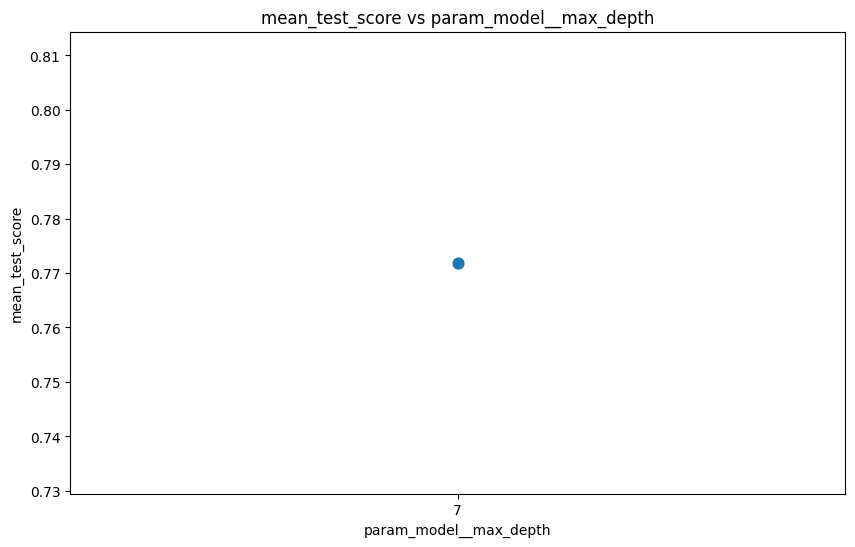

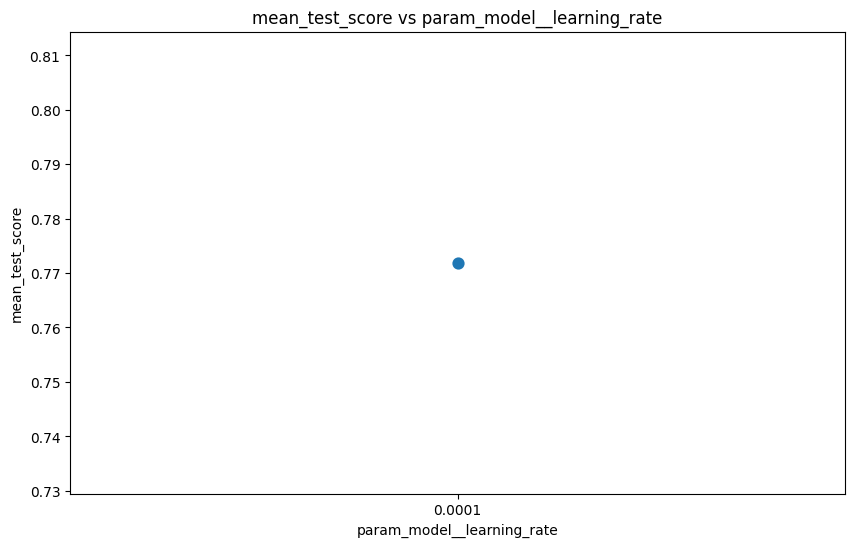

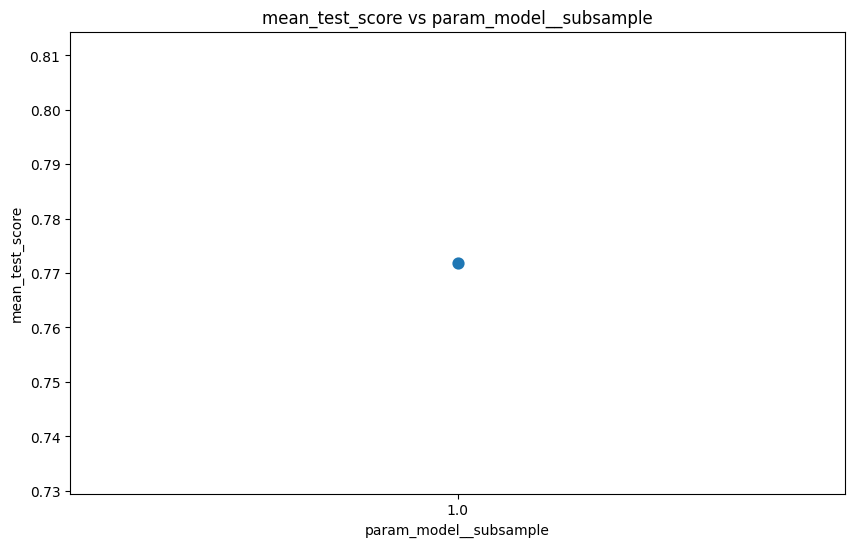

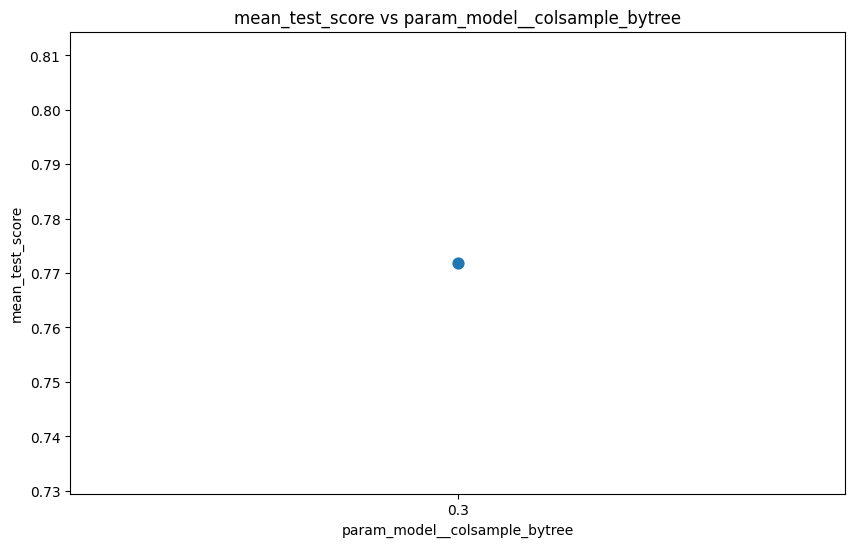

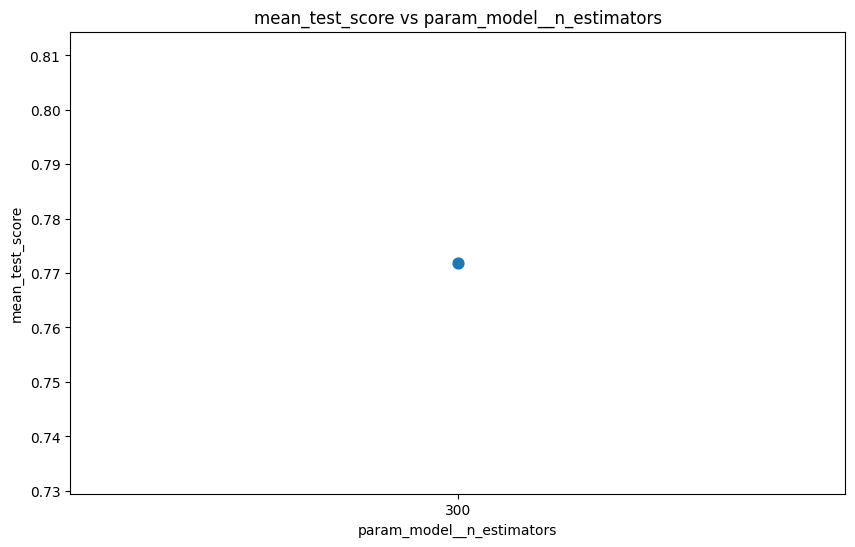

In [25]:

# Convert the cv_results_ dictionary to a DataFrame for easier manipulation
cv_results_df = pd.DataFrame(clf.cv_results_)

# Function to plot accuracy vs a single hyperparameter (or list)
def plot_hyperparameter_vs_metric(dataframe, hyperparam, metric):
    plt.figure(figsize=(10, 6))
    sns.pointplot(x=hyperparam, y=metric, data=dataframe)
    plt.title(f'{metric} vs {hyperparam}')
    plt.xlabel(hyperparam)
    plt.ylabel(metric)
    plt.show()

# Example: Plotting accuracy vs max_depth
plot_hyperparameter_vs_metric(cv_results_df, "param_model__max_depth", "mean_test_score")
# Example: Plotting accuracy vs learning_rate
plot_hyperparameter_vs_metric(cv_results_df, "param_model__learning_rate", "mean_test_score")
plot_hyperparameter_vs_metric(cv_results_df, "param_model__subsample", "mean_test_score")
plot_hyperparameter_vs_metric(cv_results_df, "param_model__colsample_bytree", "mean_test_score")
#plot_hyperparameter_vs_metric(cv_results_df, "param_model__gamma", "mean_test_score")
plot_hyperparameter_vs_metric(cv_results_df, "param_model__n_estimators", "mean_test_score")


### Example of Creating a Leaderboard Submission File

In [26]:
#columns should be ID, connected
submission_data = lb_data.filter(['ID','connected'])

In [27]:
#writing csv files
submission_data.to_csv('example_submission_data.csv',index=False)